In [63]:
# MIDTERM 1, PROBLEM 2
%matplotlib inline

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage, misc
from scipy.linalg import toeplitz
import gsvd
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [72]:
# inputs
n     = 96
m     = 96
depth = 40.0

dm = depth/float(m)
dn = depth/float(n)
depths = np.linspace(0.0,depth,m) 

# Build G
G  = np.zeros((n,m))
for i in range(n):
    for j in range(m):
        if(i*dn>j*dm):
            G[i,j]=dm
        elif(i*dn>=(j-1)*dm):
            G[i,j]=i*dn-(j-1)*dm
            
# Input model
mtrue = np.zeros((m))
for j in range(m):
    if(j>=(3*m)/8 and j<(5*m)/8):
        mtrue[j]=2.0
    else:
        mtrue[j]=2.0+3.0*float(j)/float(m)

# Input noisy data 
d  = np.zeros((n))
np.random.seed(0)
dn = np.dot(G,mtrue)+np.random.normal(0.0,0.1,n)

# weighting matrix
Wm   = np.diff(np.eye(m),2,0)   # make 2nd order 
Wm   = np.vstack([np.zeros(m), Wm, np.zeros(m)])
Wm[0,0]   = -1
Wm[0,1]   = 1 
Wm[-1,-1] = -1
Wm[-1,-2] = 1

All done gsvd!


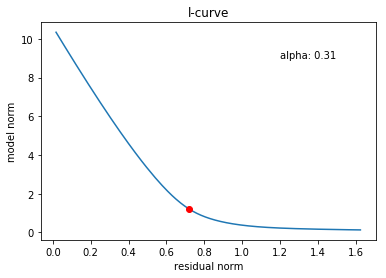

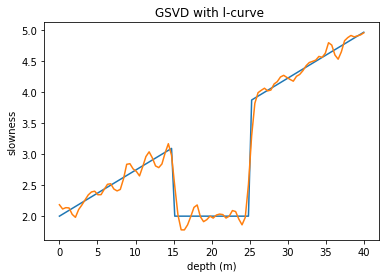

In [73]:
# part a 
# comupte generalized SVD
# find alpha using l-curve
U,V,X,C,S = gsvd.gsvd(G,Wm)
X2 = np.linalg.inv(X).T
ctc = np.dot(C.T, C)
sts = np.dot(S.T, S)
g = np.sqrt(np.diagonal(ctc)/np.diagonal(sts))
g2 = g**2
Gi2 = np.dot(np.linalg.inv(C), U.T)

ai = np.arange(.01, 10, 0.01)
an = ai.shape[0]
l2r    = np.zeros(an)
l22r   = np.zeros(an)
l2m  = np.zeros(an)
den  = np.zeros(an)
for i in range(an):
    a2       = ai[i]**2
    F = g2/(g2+a2)
    F = np.eye(n)*F
    Gi1 = np.dot(X2, F)
    Gi = np.dot(Gi1, Gi2)
    mi  = np.dot(Gi, dn)
    di       = np.dot(G, mi)
    Gmmd = dn-di
    l2r[i]   = np.sqrt(np.sum((dn-di)**2)) # l2 norm of model residual
    lm       = np.dot(Wm,mi)
    l2m[i]   = np.sqrt(np.sum((lm)**2)) # l2 norm of model residual
    # for GCV in part b
    l22r[i]   = np.sum((dn-di)**2)
    den[i]    = np.trace(np.eye(n)-np.dot(G, Gi))**2


# plot l-curve 
abest = 30
ax = plt.subplot(111)
plt.plot(l2r, l2m)
plt.plot(l2r[abest], l2m[abest],"ro")
ax.set_xlabel("residual norm")
ax.set_ylabel("model norm")
plt.title('l-curve')
plt.annotate('alpha: '+str(ai[abest]),(1.2,9))
plt.show()

# find preferred model using l-curve
amin = ai[abest]**2
F    = g2/(g2+amin)
F    = np.eye(n)*F
Gi1  = np.dot(X2, F)
Gi   = np.dot(Gi1, Gi2)
mestgsvd  = np.dot(Gi, dn)
    
# plot preferred model using l-curve
ax=plt.subplot(111)
plt.plot(depths, mtrue, depths, mestgsvd)
ax.set_xlabel("depth (m)")
ax.set_ylabel("slowness")
plt.title('GSVD with l-curve ')
plt.show()


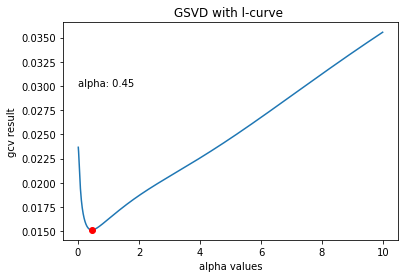

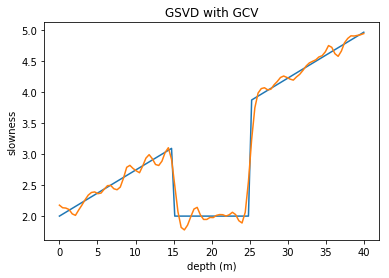

In [74]:
# part b 
# generalized cross validation 
#||Gm-d||22 = (Gm-d)T*(Gm-d)
gcv  = (n*l22r)/den
mgcv = np.argmin(gcv)
amin = ai[mgcv]**2

# plot gcv vs alpha to show minimum
ax=plt.subplot(111)
plt.plot(ai, gcv)
plt.plot(ai[mgcv], gcv[mgcv],"ro")
ax.set_xlabel("alpha values")
ax.set_ylabel("gcv result")
plt.title('GSVD with l-curve ')
plt.annotate('alpha: '+str(ai[mgcv]),(0, 0.03))
plt.show()

# compute mest using alpha that equals min(gcv)
F    = g2/(g2+amin)
F    = np.eye(n)*F
Gi1  = np.dot(X2, F)
Gi   = np.dot(Gi1, Gi2)
mestgcv  = np.dot(Gi, dn)

# plot preferred model using gcv
ax=plt.subplot(111)
plt.plot(depths, mtrue, depths, mestgcv)
ax.set_xlabel("depth (m)")
ax.set_ylabel("slowness")
plt.title('GSVD with GCV')
plt.show()

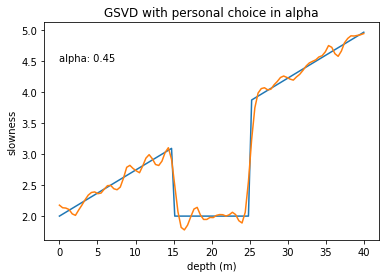

In [75]:
# part c
# choice in alpha: GCV method
amin = ai[mgcv]**2
F    = g2/(g2+amin)
F    = np.eye(n)*F
Gi1  = np.dot(X2, F)
Gi   = np.dot(Gi1, Gi2)
mestme  = np.dot(Gi, dn)

# plot
ax=plt.subplot(111)
plt.plot(depths, mtrue, depths, mestme)
ax.set_xlabel("depth (m)")
ax.set_ylabel("slowness")
plt.title('GSVD with personal choice in alpha')
plt.annotate('alpha: '+str(ai[mgcv]),(0, 4.5))
plt.show()